## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


sns.set_theme()

## Loading the raw data

In [2]:
df_main = pd.read_csv('cars_dataset.csv')
df = df_main.copy()
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [3]:
df.shape

(4345, 9)

## Preprocessing

### Exploring the Descriptive Statistics of the Variables

In [4]:
df.describe(include='all').round(2)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.00,4345,4345.00,4195.00,4345,4345,4345.00,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.75,NaN,161.24,2.79,NaN,NaN,2006.55,NaN
std,NaN,25584.24,NaN,105.71,5.07,NaN,NaN,6.72,NaN
min,NaN,600.00,NaN,0.00,0.60,NaN,NaN,1969.00,NaN
25%,NaN,6999.00,NaN,86.00,1.80,NaN,NaN,2003.00,NaN
50%,NaN,11500.00,NaN,155.00,2.20,NaN,NaN,2008.00,NaN
75%,NaN,21700.00,NaN,230.00,3.00,NaN,NaN,2012.00,NaN


### Determining the Variables of Interest

In [5]:
df = df.drop(['Model','Registration'], axis=1)

### Dealing with Missing Values

In [6]:
df.isnull().sum()

Brand            0
Price          172
Body             0
Mileage          0
EngineV        150
Engine Type      0
Year             0
dtype: int64

In [7]:
df[:20]

,Brand,Price,Body,Mileage,EngineV,Engine Type,Year
0,BMW,4200.0,sedan,277,2.00,Petrol,1991
1,Mercedes-Benz,7900.0,van,427,2.90,Diesel,1999
2,Mercedes-Benz,13300.0,sedan,358,5.00,Gas,2003
3,Audi,23000.0,crossover,240,4.20,Petrol,2007
4,Toyota,18300.0,crossover,120,2.00,Petrol,2011
5,Mercedes-Benz,199999.0,crossover,0,5.50,Petrol,2016
6,BMW,6100.0,sedan,438,2.00,Gas,1997
7,Audi,14200.0,vagon,200,2.70,Diesel,2006
8,Renault,10799.0,vagon,193,1.50,Diesel,2012
9,Volkswagen,1400.0,other,212,1.80,Gas,1999


In [8]:
df.dropna(axis=0, ignore_index=True, inplace=True)

In [9]:
df.isnull().sum()

Brand          0
Price          0
Body           0
Mileage        0
EngineV        0
Engine Type    0
Year           0
dtype: int64

In [10]:
df.shape

(4025, 7)

### Exploring the Distribution of Price Variable

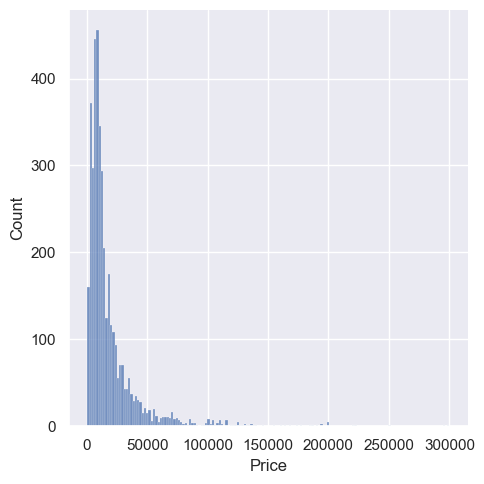

In [11]:
sns.displot(df['Price'])
plt.show()

### Dealing with Outliers

In [12]:
q = df['Price'].quantile(0.99)
df = df[df['Price']<q]

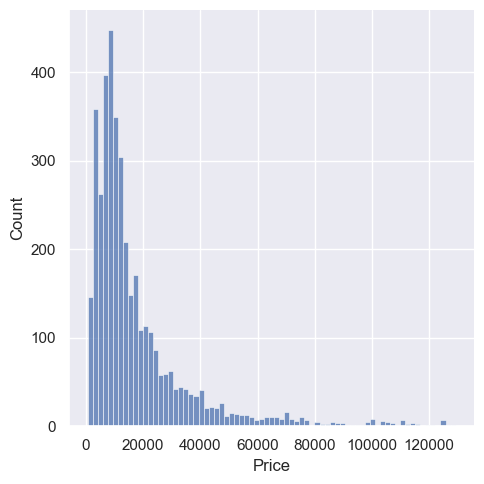

In [13]:
sns.displot(df['Price'])
plt.show()

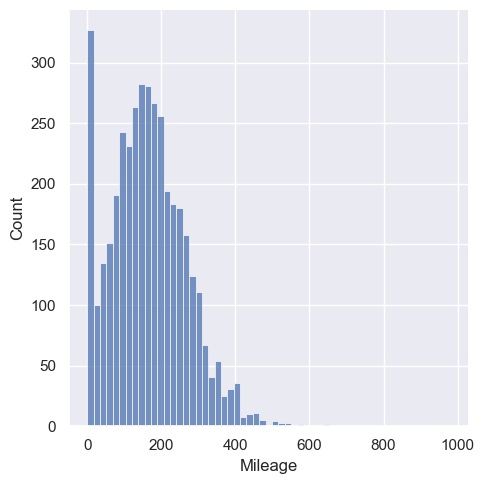

In [14]:
sns.displot(df['Mileage'])
plt.show()

In [15]:
q = df['Mileage'].quantile(0.99)
df = df[df['Mileage']<q]

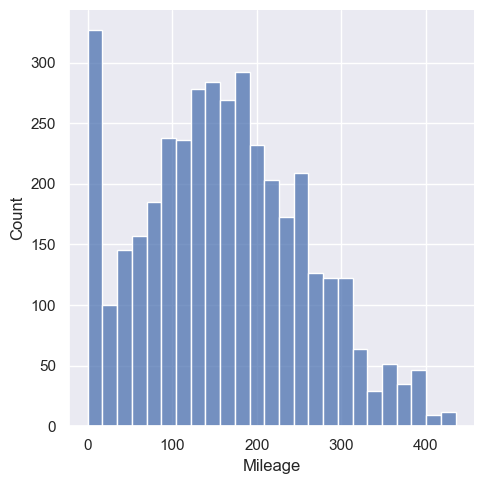

In [16]:
sns.displot(df['Mileage'])
plt.show()

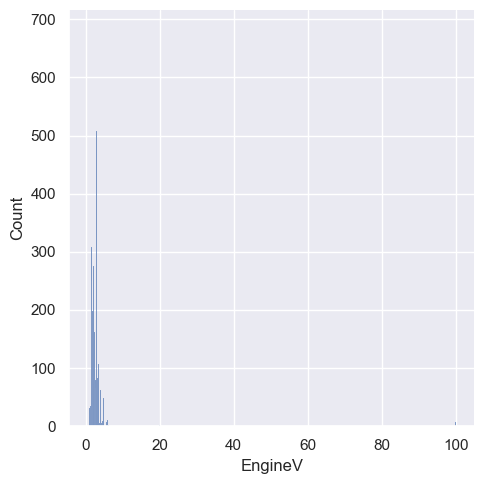

In [17]:
sns.displot(df['EngineV'])
plt.show()

In [18]:
df = df[df['EngineV']<6.5]

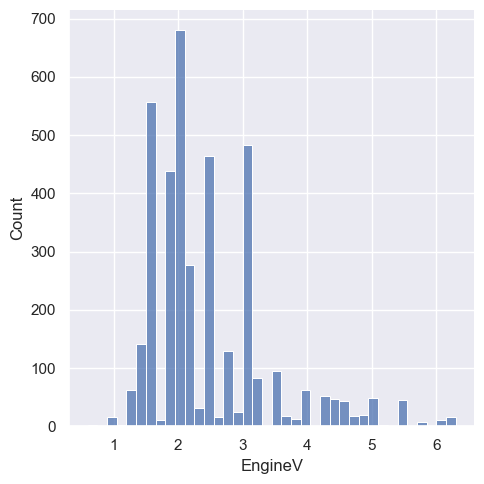

In [19]:
sns.displot(df['EngineV'])
plt.show()

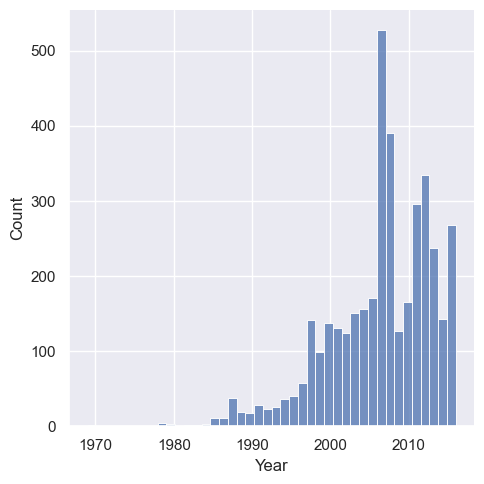

In [20]:
sns.displot(df['Year'])
plt.show()

In [21]:
q = df['Year'].quantile(0.01)
df = df[df['Year']>q]

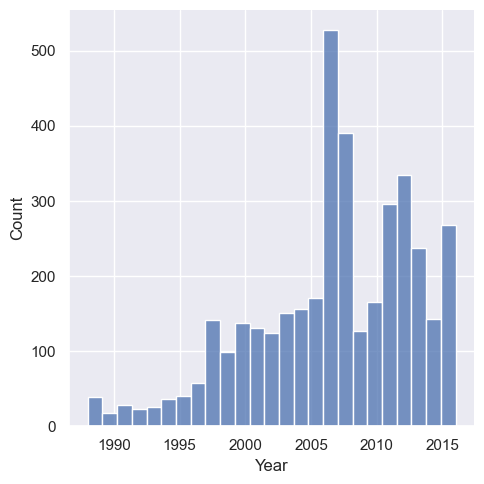

In [22]:
sns.displot(df['Year'])
plt.show()

In [23]:
df.reset_index(drop=True, inplace=True)

### Categorizing Variables

In [24]:
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,2011


In [25]:
df.nunique()

Brand            7
Price          849
Body             6
Mileage        377
EngineV         55
Engine Type      4
Year            29
dtype: int64

In [26]:
# Initialize BinaryEncoder
binary_encoder = ce.BinaryEncoder()

# Fit and transform the data
df_encoded = binary_encoder.fit_transform(df)

In [27]:
df_encoded.head()

,Brand_0,Brand_1,Brand_2,Price,Body_0,Body_1,Body_2,Mileage,EngineV,Engine Type_0,Engine Type_1,Engine Type_2,Year
0,0,0,1,4200.0,0,0,1,277,2.0,0,0,1,1991
1,0,1,0,7900.0,0,1,0,427,2.9,0,1,0,1999
2,0,1,0,13300.0,0,0,1,358,5.0,0,1,1,2003
3,0,1,1,23000.0,0,1,1,240,4.2,0,0,1,2007
4,1,0,0,18300.0,0,1,1,120,2.0,0,0,1,2011


In [28]:
df_encoded.dtypes

Brand_0            int64
Brand_1            int64
Brand_2            int64
Price            float64
Body_0             int64
Body_1             int64
Body_2             int64
Mileage            int64
EngineV          float64
Engine Type_0      int64
Engine Type_1      int64
Engine Type_2      int64
Year               int64
dtype: object

In [29]:
df_encoded.nunique()

Brand_0            2
Brand_1            2
Brand_2            2
Price            849
Body_0             2
Body_1             2
Body_2             2
Mileage          377
EngineV           55
Engine Type_0      2
Engine Type_1      2
Engine Type_2      2
Year              29
dtype: int64

## Checking the OLS assumptions

In [30]:
y = df_encoded["Price"]
X = df_encoded.drop("Price", axis=1)

### Linearity

In [31]:
# Identify boolean-like columns (columns with only 0 and 1)
boolean_X = [col for col in X.columns if set(X[col].unique()).issubset({0, 1})]

# Exclude boolean-like columns and select only continuous columns
non_boolean_X = X.drop(columns=boolean_X, axis=0)

# Display the new DataFrame
print(non_boolean_X)

      Mileage  EngineV  Year
0         277      2.0  1991
1         427      2.9  1999
2         358      5.0  2003
3         240      4.2  2007
4         120      2.0  2011
...       ...      ...   ...
3862      163      2.5  2008
3863       35      1.6  2014
3864        9      3.0  2014
3865        1      3.5  1999
3866      124      2.0  2013

[3867 rows x 3 columns]


In [32]:
def fn(x, y):

    b1_slope, b0_intercept = np.polyfit(x, y, 1)
    y_pred = b0_intercept + x * b1_slope

    plt.figure(figsize=(6,3))
    plt.title(x.name + " and " + y.name)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red', label='Regression Line')
    plt.show()

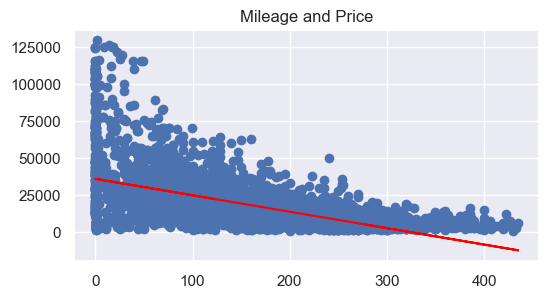

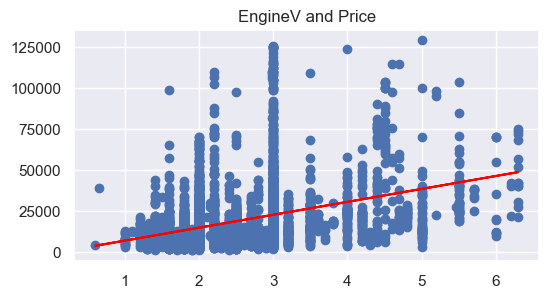

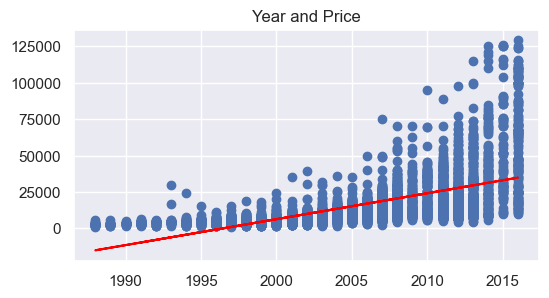

In [33]:
for col in non_boolean_X.columns:
    fn(df_encoded[col], df_encoded['Price'])

In [34]:
log_price = np.log(df_encoded["Price"])
df_encoded["log_price"] = log_price
df_encoded.head()

,Brand_0,Brand_1,Brand_2,Price,Body_0,Body_1,Body_2,Mileage,EngineV,Engine Type_0,Engine Type_1,Engine Type_2,Year,log_price
0,0,0,1,4200.0,0,0,1,277,2.0,0,0,1,1991,8.342840
1,0,1,0,7900.0,0,1,0,427,2.9,0,1,0,1999,8.974618
2,0,1,0,13300.0,0,0,1,358,5.0,0,1,1,2003,9.495519
3,0,1,1,23000.0,0,1,1,240,4.2,0,0,1,2007,10.043249
4,1,0,0,18300.0,0,1,1,120,2.0,0,0,1,2011,9.814656


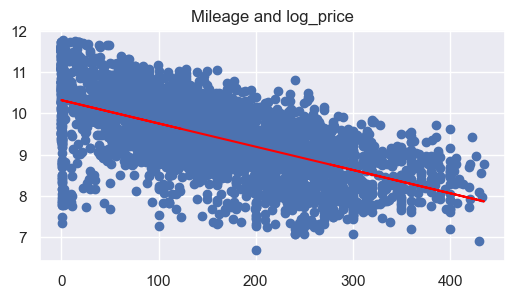

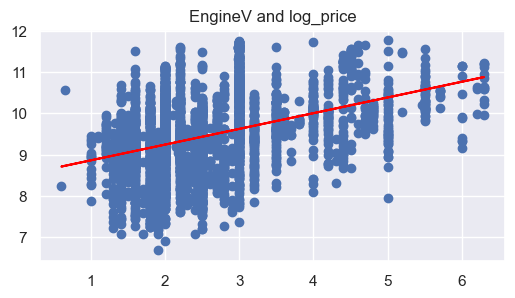

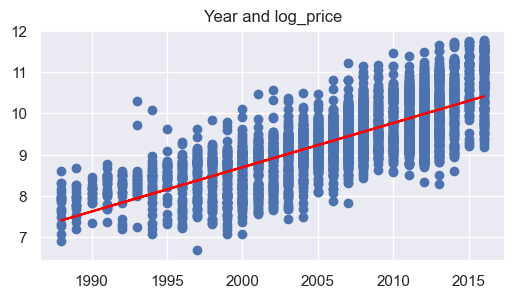

In [35]:
for col in non_boolean_X.columns:
    fn(df_encoded[col], df_encoded["log_price"])

### Constant Variance / Homoscedasticity / No Heteroscedasticity

In [36]:
y = df_encoded["log_price"]

In [ ]:
# Fit the OLS model
x = sm.add_constant(X)
model = sm.OLS(df_encoded["Price"], x).fit()

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog) 

# Get the p-value
p_value = bp_test[1] 

# Print the results
print(f"Breusch-Pagan Test p-value for the Model: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis of homoscedasticity.")
    print("There is evidence of heteroscedasticity.")
    print(f"The model is significant.\n")
else:
    print("Fail to reject the null hypothesis of homoscedasticity.")
    print("There is no evidence of heteroscedasticity.")
    print(f"The model is insignificant.\n")

Breusch-Pagan Test p-value for the Model: 1.907972251202714e-92
Reject the null hypothesis of homoscedasticity.
There is evidence of heteroscedasticity.
The model is significant.



### No Endogeneity / Exogeneity

In [ ]:
X["residuals"] = model.resid

In [50]:
resid_corr = X.corr().loc[["residuals"]] 
resid_corr

,Brand_0,Brand_1,Brand_2,Body_0,Body_1,Body_2,Mileage,EngineV,Engine Type_0,Engine Type_1,Engine Type_2,Year,residuals
residuals,1.885436e-15,-1.317623e-15,-2.465996e-15,2.207015e-15,6.904373e-15,3.467151e-15,-5.375538e-14,-3.490253e-16,-1.582381e-15,-6.860306e-15,1.342851e-15,4.732076e-14,1.0


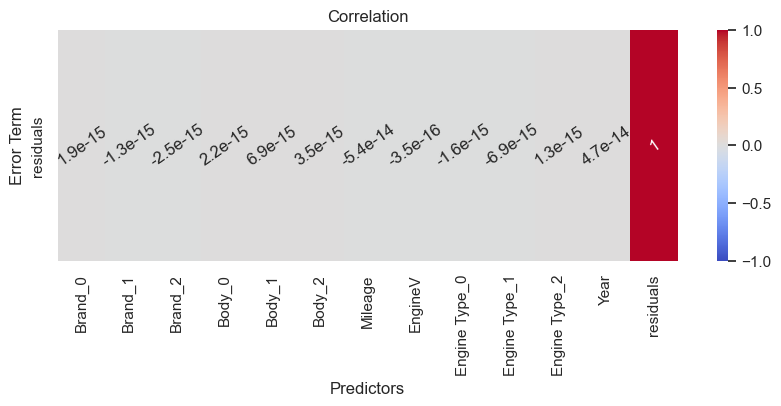

<Figure size 640x480 with 0 Axes>

In [69]:
# Heatmap of Numeric Values Only
plt.figure(figsize=(10,3))
sns.heatmap(resid_corr, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            annot_kws={"rotation": 35}
)

plt.title('Correlation')
plt.ylabel('Error Term')
plt.xlabel('Predictors')
plt.show()
plt.clf()

### No Autocorrelation / Independant Error Terms / No Serial Correlation

### Normal Errors

### No Multicollinearity

### Relaxing the assumptions

In [ ]:
log_price = np.log(df_processed['Price'])
df_processed['log_price'] = log_price
df_processed.head()

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,7))

ax1.scatter(df_processed['Year'],df_processed['log_price'])
ax1.set_title('Log Price and Year')

ax2.scatter(df_processed['EngineV'],df_processed['log_price'])
ax2.set_title('Log Price and EngineV')

ax3.scatter(df_processed['Mileage'],df_processed['log_price'])
ax3.set_title('Log Price and Mileage')


plt.show()

In [ ]:
data_cleaned = df_processed.drop(['Price'],axis=1)

### Multicollinearity

In [ ]:
data_cleaned.columns.values

In [ ]:
variables = data_cleaned[['Mileage','Year','EngineV']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns

In [ ]:
data_no_multicollinearity = data_cleaned.drop(['Year'],axis=1)
data_no_multicollinearity

## Create dummy variables

In [ ]:
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first=True)

In [ ]:
data_with_dummies.head()

### Rearrange a bit

In [ ]:
data_with_dummies.columns.values

In [ ]:
cols = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol']

In [ ]:
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head()

## Linear regression model

### Declare the inputs and the targets

In [ ]:
targets = data_preprocessed['log_price']
inputs = data_preprocessed.drop(['log_price'],axis=1)

### Scale the data

In [ ]:
scaler = StandardScaler()
scaler.fit(inputs)

In [ ]:
inputs_scaled = scaler.transform(inputs)

### Train Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=365)

### Create the regression

In [ ]:
reg = LinearRegression()
reg.fit(x_train,y_train)

In [ ]:
y_hat = reg.predict(x_train)

In [ ]:
plt.scatter(y_train, y_hat)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [ ]:
#Residual is the difference between the targets and the predictions
sns.displot(y_train - y_hat)
plt.title("Residuals PDF", size=18)

In [ ]:
reg.score(x_train,y_train)

### Finding the weights and bias

In [ ]:
reg.intercept_

In [ ]:
reg.coef_

In [ ]:
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

## Testing

In [ ]:
y_hat_test = reg.predict(x_test)

In [ ]:
x_test

In [ ]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [ ]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

In [ ]:
df_pf['Target'] = np.exp(y_test)
df_pf

In [ ]:
y_test = y_test.reset_index(drop=True)
y_test.head()

In [ ]:
df_pf['Target'] = np.exp(y_test)
df_pf

In [ ]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [ ]:
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

In [ ]:
df_pf.describe()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by=['Difference%'])

In [ ]:
reg.feature_names_in_

In [ ]:
reg.predict(np.array([0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0]).reshape(1, -1))